In [ ]:
#Importing libraries
import os
import seaborn as sns
import pandas as pd
import numpy as np
import cv2 as cv
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

In [ ]:
os.environ['KAGGLE_USERNAME'] = ""
os.environ['KAGGLE_KEY'] = ""
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k

100% 1.62G/1.62G [00:08<00:00, 189MB/s]
100% 1.62G/1.62G [00:08<00:00, 206MB/s]


In [ ]:
!unzip ocular-disease-recognition-odir5k.zip

Streaming output truncated to the last 5000 lines.
  inflating: preprocessed_images/2179_left.jpg  
  inflating: preprocessed_images/2179_right.jpg  
  inflating: preprocessed_images/217_left.jpg  
  inflating: preprocessed_images/217_right.jpg  
  inflating: preprocessed_images/2180_left.jpg  
  inflating: preprocessed_images/2180_right.jpg  
  inflating: preprocessed_images/2181_left.jpg  
  inflating: preprocessed_images/2181_right.jpg  
  inflating: preprocessed_images/2182_left.jpg  
  inflating: preprocessed_images/2182_right.jpg  
  inflating: preprocessed_images/2183_left.jpg  
  inflating: preprocessed_images/2183_right.jpg  
  inflating: preprocessed_images/2184_left.jpg  
  inflating: preprocessed_images/2184_right.jpg  
  inflating: preprocessed_images/2185_left.jpg  
  inflating: preprocessed_images/2185_right.jpg  
  inflating: preprocessed_images/2187_left.jpg  
  inflating: preprocessed_images/2187_right.jpg  
  inflating: preprocessed_images/2189_left.jpg  
  inflating

In [ ]:
dataset = pd.read_csv("/content/full_df.csv")

In [ ]:
dataset

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6387,4686,63,Male,4686_left.jpg,4686_right.jpg,severe nonproliferative retinopathy,proliferative diabetic retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4686_left.jpg
6388,4688,42,Male,4688_left.jpg,4688_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4688_left.jpg
6389,4689,54,Male,4689_left.jpg,4689_right.jpg,mild nonproliferative retinopathy,normal fundus,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4689_left.jpg
6390,4690,57,Male,4690_left.jpg,4690_right.jpg,mild nonproliferative retinopathy,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4690_left.jpg


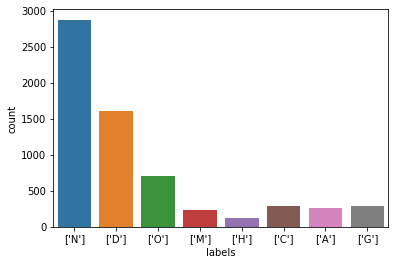

In [ ]:
sns.countplot(x=dataset['labels'], data=dataset)

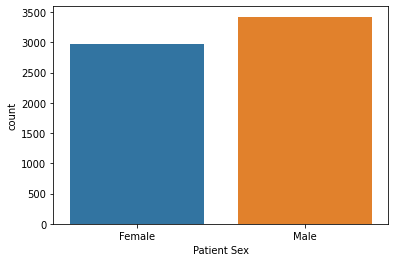

In [ ]:
sns.countplot(x=dataset['Patient Sex'], data=dataset)

(array([  28.,    8.,   29.,  223.,  589., 1378., 2057., 1511.,  486.,
          83.]),
 array([ 1., 10., 19., 28., 37., 46., 55., 64., 73., 82., 91.]),
 <a list of 10 Patch objects>)

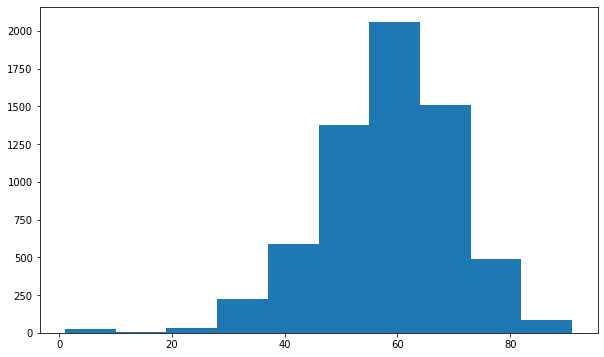

In [ ]:
plt.figure(figsize= (10,6))
plt.hist(dataset['Patient Age'])

## Extracting definitive diagnosis per patient.

In [ ]:
def has_cataract(text):
    if "cataract" in text:
        return 2
    else:
        return 0

dataset['left_cataract'] = dataset['Left-Diagnostic Keywords'].apply(lambda x: has_cataract(x))  #lambda is filter function

dataset['right_cataract'] = dataset['Right-Diagnostic Keywords'].apply(lambda x: has_cataract(x))

left_cataract = dataset.loc[(dataset.C == 1) & (dataset['left_cataract'] == 2)]['Left-Fundus'].values
right_cataract = dataset.loc[(dataset.C == 1) & (dataset['right_cataract'] == 2)]['Right-Fundus'].values
cataract = np.concatenate((left_cataract, right_cataract), axis=0)

In [ ]:
def has_normal_fundus(text):
    if "normal fundus" in text:
        return 1
    else:
        return 0

dataset['left_normal'] = dataset['Left-Diagnostic Keywords'].apply(lambda x: has_normal_fundus(x))
dataset['right_normal'] = dataset['Right-Diagnostic Keywords'].apply(lambda x: has_normal_fundus(x))

left_normal = dataset.loc[(dataset.N == 1) & (dataset['left_normal'] == 1)]["Left-Fundus"].values
right_normal = dataset.loc[(dataset.N == 1) & (dataset["right_normal"] == 1)]["Right-Fundus"].values
normal = np.concatenate((left_normal, right_normal), axis=0)

In [ ]:
def has_retinopathy(text):
  if ('mild nonproliferative retinopathy') or ('proliferative retinopathy') or ('diabetic retinopathy') or ('moderate non proliferative retinopathy') in text:
    return 3
  else:
    return 0

dataset['left_diabetes'] = dataset['Left-Diagnostic Keywords'].apply(lambda x: has_retinopathy(x))
dataset['right_diabetes'] = dataset['Right-Diagnostic Keywords'].apply(lambda x: has_retinopathy(x))

left_diabetes = dataset.loc[(dataset.D == 1) & (dataset['left_diabetes'] == 3)]['Left-Fundus'].values
right_diabetes = dataset.loc[(dataset.D == 1) & (dataset['right_diabetes'] == 3)]['Right-Fundus'].values
diabetes = np.concatenate((left_diabetes, right_diabetes), axis=0)

In [ ]:
def has_glaucoma(text):
  if 'glaucoma' in text:
    return 4
  else:
    return 0

dataset['left_glaucoma'] = dataset['Left-Diagnostic Keywords'].apply(lambda x: has_glaucoma(x))
dataset['right_glaucoma'] = dataset['Left-Diagnostic Keywords'].apply(lambda x: has_glaucoma(x))

left_glaucoma = dataset.loc[(dataset.G == 1) & (dataset['left_glaucoma'] == 4)]['Left-Fundus'].values
right_glaucoma = dataset.loc[(dataset.G == 1) & (dataset['right_glaucoma'] == 4)]['Right-Fundus'].values
glaucoma = np.concatenate((left_glaucoma, right_glaucoma), axis=0)

In [ ]:
def has_amd(text):
  if ('macular degeneration') in text:
    return 5
  else:
    return 0

dataset['left_macular degeneration'] = dataset['Left-Diagnostic Keywords'].apply(lambda x: has_retinopathy(x))
dataset['right_macular degeneration'] = dataset['Right-Diagnostic Keywords'].apply(lambda x: has_retinopathy(x))

left_diabetes = dataset.loc[(dataset.D == 1) & (dataset['left_diabetes'] == 3)]['Left-Fundus'].values
right_diabetes = dataset.loc[(dataset.D == 1) & (dataset['right_diabetes'] == 3)]['Right-Fundus'].values
diabetes = np.concatenate((left_diabetes, right_diabetes), axis=0)

In [ ]:
print(len(cataract), len(normal), len(glaucoma), len(diabetes))

594 4201 664 4246


In [ ]:
dataset_dir = "/content/preprocessed_images/"
image_size = 224
labels = []
ds = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv.imread(image_path,cv.IMREAD_COLOR)
            image = cv.resize(image,(image_size,image_size))
        except:
            continue

        ds.append([np.array(image), np.array(label)])
    random.shuffle(ds)
    return ds

In [ ]:
ds = create_dataset(cataract, 1)
ds = create_dataset(glaucoma, 3)
ds = create_dataset(normal, 0)
ds = create_dataset(diabetes, 2)

100%|██████████| 4246/4246 [00:19<00:00, 217.86it/s]


In [ ]:
len(ds)

9544

In [ ]:
# Shape of the new dataset
np.shape(ds)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


(9544, 2)

In [ ]:
# Taking a look at new dataset
ds

[[array([[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         ...,
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]], dtype=uint8), array(1)], [array([[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0,

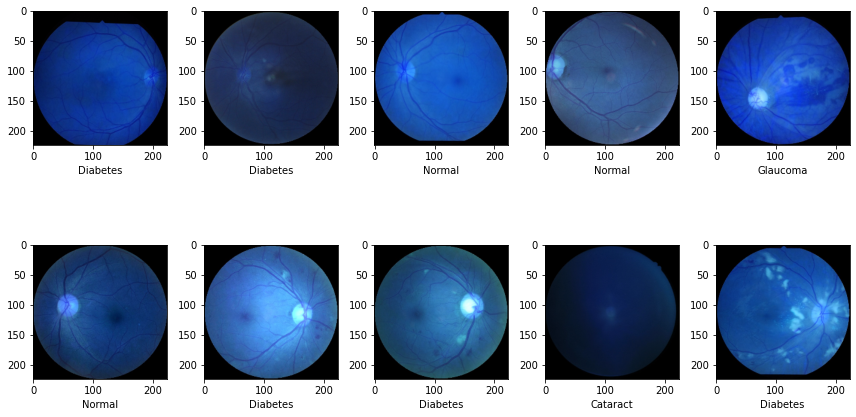

In [ ]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(ds)))
    image = ds[sample][0]
    label = ds[sample][1]
    if label == 0:
      label = "Normal"
    elif label == 1:
      label = "Cataract"
    elif label == 2:
      label = "Diabetes"
    elif label == 3:
      label = "Glaucoma"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()

In [ ]:
x = np.array([i[0] for i in ds]).reshape(-1,image_size,image_size,3)
y = to_categorical([i[1] for i in ds])

In [ ]:
# Splitting the dataset into train, validation and test sets

from sklearn.model_selection import train_test_split
X_train,X_val,Y_train,Y_val = train_test_split(x,y,test_size=0.2)
X_val,X_test,Y_val,Y_test = train_test_split(X_val, Y_val, test_size=0.5)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_test.shape)
print(Y_val.shape)

(7635, 224, 224, 3)
(955, 224, 224, 3)
(954, 224, 224, 3)
(7635, 4)
(955, 4)
(954, 4)


## Instantiating and training model

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
vgg = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape= (224,224,3)
)
vgg.trainable = False

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
x = Flatten()(vgg.output)
dense1 = Dense(units=128,activation='relu')(x)
dense2 = Dense(units=128, activation='relu')(dense1)
output = Dense(units=4, activation='softmax')(dense2)
A = Model(inputs = vgg.input, outputs = output)
A.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
optim = tf.keras.optimizers.Adam(learning_rate = 0.00001)
A.compile(optimizer= optim, loss= 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
training = A.fit(x=X_train, y=Y_train, batch_size=128, epochs=20, validation_data=(X_val, Y_val))

Epoch 1/20
60/60 [==============================] - 68s 796ms/step - loss: 2.1963 - accuracy: 0.4377 - val_loss: 1.4958 - val_accuracy: 0.4990
Epoch 2/20
60/60 [==============================] - 40s 663ms/step - loss: 1.2385 - accuracy: 0.5433 - val_loss: 1.1961 - val_accuracy: 0.5545
Epoch 3/20
60/60 [==============================] - 41s 686ms/step - loss: 0.9718 - accuracy: 0.6055 - val_loss: 1.0528 - val_accuracy: 0.5765
Epoch 4/20
60/60 [==============================] - 41s 678ms/step - loss: 0.8027 - accuracy: 0.6678 - val_loss: 0.9532 - val_accuracy: 0.6184
Epoch 5/20
60/60 [==============================] - 41s 684ms/step - loss: 0.6800 - accuracy: 0.7215 - val_loss: 0.8726 - val_accuracy: 0.6342
Epoch 6/20
60/60 [==============================] - 41s 683ms/step - loss: 0.5815 - accuracy: 0.7639 - val_loss: 0.8115 - val_accuracy: 0.6572
Epoch 7/20
60/60 [==============================] - 41s 683ms/step - loss: 0.5036 - accuracy: 0.8046 - val_loss: 0.7462 - val_accuracy: 0.6939

In [ ]:
accuracy = A.evaluate(X_test, Y_test)

30/30 [==============================] - 10s 234ms/step - loss: 0.4557 - accuracy: 0.8450


In [ ]:
Y_pred = A.predict(X_test)
print(Y_pred)

[[1.9821520e-01 4.3637138e-03 7.8663832e-01 1.0782734e-02]
 [6.3961285e-01 1.2961532e-03 2.4294370e-01 1.1614732e-01]
 [4.1832559e-02 6.0455957e-05 9.5096439e-01 7.1426504e-03]
 ...
 [9.3914348e-01 2.3071539e-04 5.5995326e-02 4.6304930e-03]
 [7.9563808e-01 3.0554958e-05 2.0371345e-01 6.1791629e-04]
 [8.6292073e-02 1.0534011e-06 8.5224748e-01 6.1459385e-02]]


In [ ]:
Y_pred = np.argmax(Y_pred, axis=1)
Y_test = np.argmax(Y_test, axis=1)

AxisError: ignored

## Checking model performance

In [ ]:
cm = confusion_matrix(Y_test, Y_pred, labels= [0,1,2,3])

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix
[[0.8872549  0.00735294 0.09803922 0.00735294]
 [0.04761905 0.83333333 0.11904762 0.        ]
 [0.13318284 0.02031603 0.8261851  0.02031603]
 [0.08064516 0.01612903 0.19354839 0.70967742]]


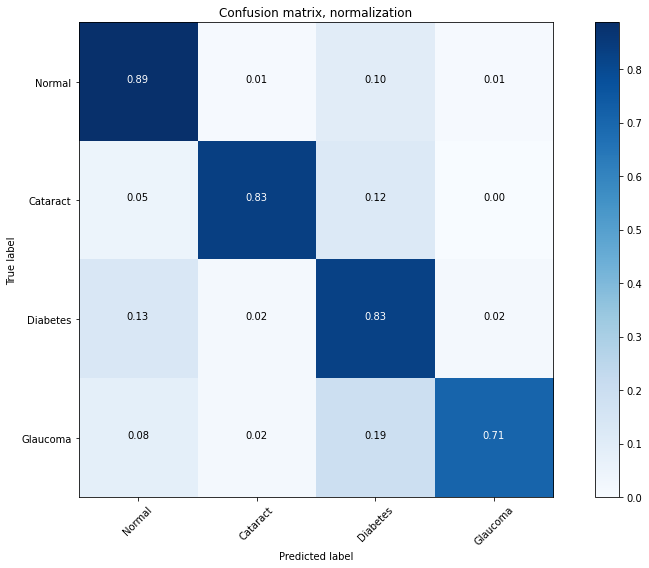

In [ ]:
plt.figure(figsize=(12,8))
plot_confusion_matrix(cm, classes=['Normal', 'Cataract', 'Diabetes', 'Glaucoma'], title='Confusion matrix, normalization')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred, target_names=['Normal', 'Cataract', 'Diabetes', 'Glaucoma']))

              precision    recall  f1-score   support

      Normal       0.85      0.89      0.87       408
    Cataract       0.73      0.83      0.78        42
    Diabetes       0.87      0.83      0.85       443
    Glaucoma       0.79      0.71      0.75        62

    accuracy                           0.85       955
   macro avg       0.81      0.81      0.81       955
weighted avg       0.85      0.85      0.84       955



In [ ]:
accuracy_score(Y_test, Y_pred, normalize=True)

0.8450261780104712

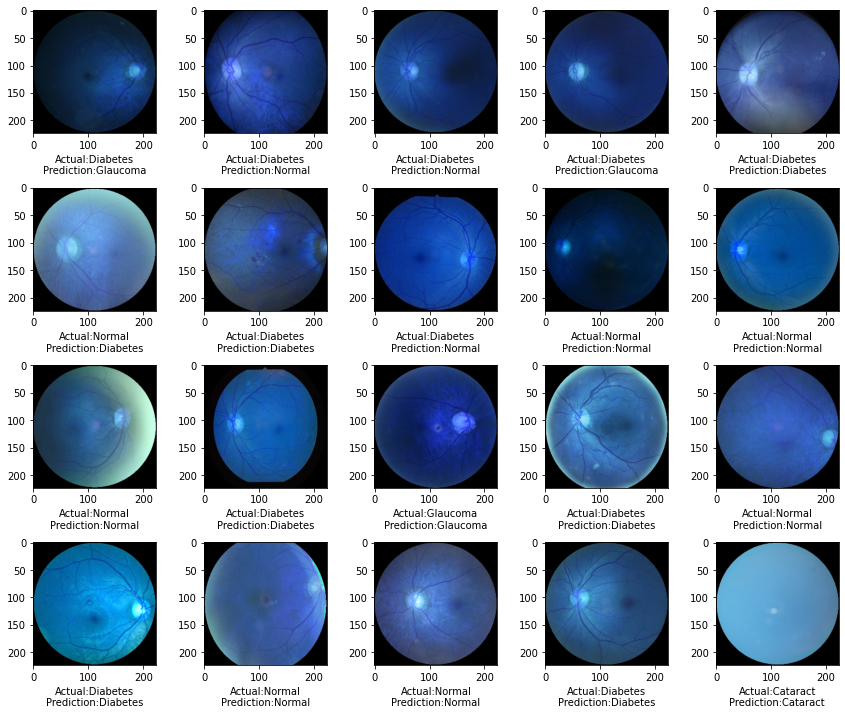

In [ ]:
plt.figure(figsize=(12,10))
for i in range(20):
    sample = random.choice(range(len(X_test)))
    image = X_test[sample]
    category = Y_test[sample]
    pred_category = Y_pred[sample]

    if category== 0:
        label = "Normal"
    elif category == 1:
        label = "Cataract"
    elif category == 2:
        label = "Diabetes"
    elif category == 3:
        label = "Glaucoma"

    if pred_category== 0:
        pred_label = "Normal"
    elif pred_category == 1:
        pred_label = "Cataract"
    elif pred_category == 2:
        pred_label = "Diabetes"
    elif pred_category == 3:
        pred_label = "Glaucoma"

    plt.subplot(4,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout()

## Trying out model on completely new image loaded from system

In [ ]:
# Loading in new image

new_image = cv.imread('/content/normal_fundus (2).jfif')
new_image = cv.cvtColor(new_image, cv.COLOR_BGR2RGB)
new_image = cv.resize(new_image, (224,224))

error: ignored

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(new_image)

In [ ]:
# Running model on new image

copy_new_image = np.array(new_image).reshape(-1,224,224,3)
new_prediction = A.predict(copy_new_image)

In [ ]:
np = np.argmax(new_prediction, axis=1)

In [ ]:
# Printing out prediction
np